## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images



In [4]:
## Import all necessary libraries
%matplotlib inline
#%matplotlib qt
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
import math
import os





In [5]:
nx=9
ny=6

def calibrate(nx,ny):
    undist=[]
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image_store=[]
    image=[]
    undst=[]
    global ret, mtx ,dist ,rvecs ,tvecs
    images = glob.glob('camera_cal/calibration*.jpg')
    k=0
    l=0
    for fname in images:
        k+=1
        img = cv2.imread(fname)
        image.append(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        image_store.append(img)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)      
            l+=1
    ret, mtx ,dist ,rvecs ,tvecs = cv2.calibrateCamera(objpoints,imgpoints,(gray.shape[0],gray.shape[1]),None,None)
    return ret, mtx, dist, rvecs, tvecs

In [6]:
calib=calibrate(nx,ny)


In [7]:
image=cv2.imread('test_images/test3.jpg')

In [8]:
def undistort(image,mtx,dist,):        
    undist=cv2.undistort(image,mtx,dist,None,mtx)
    return undist

def abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(0, 255)):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
    
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx=(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely=(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    sob_power=np.sqrt(sobelx**2+sobely**2)
    sob_scale=np.uint8(255*sob_power/np.max(sob_power))
    binary_output=np.zeros_like(sob_scale)
    binary_output[(sob_scale>mag_thresh[0])&(sob_scale<mag_thresh[1])]=1
    return binary_output
    
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    absx=np.absolute(sobelx)
    absy=np.absolute(sobely)
    magnitude=np.absolute(np.arctan2(absy,absx))
    binary_output=np.zeros_like(magnitude)
    binary_output[(magnitude>thresh[0])&(magnitude<thresh[1])]=1# Remove this line
    return binary_output
    
def sob(image,ksize):
    image=cv2.GaussianBlur(image,(ksize,ksize),11)

    ksize = 11 # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(50,80))#30, 120
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(80, 120))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(120,250))#120, 250
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.3))
    return gradx,grady,mag_binary,dir_binary

def color_threshold(image,ksize,std):
    image=cv2.GaussianBlur(image,(ksize,ksize),std)       
    HSV = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    HLS = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    #HH,SS,VV=cv2.split(image)
    HH=HSV[:,:,0]
    LL=HLS[:,:,1]
    VV=HSV[:,:,2]
#######################################################################   
   
    sL_thresh=(220,255)#218,255
    sobelL = cv2.Sobel(LL, cv2.CV_64F,1,0) # Take the derivative in x
    abs_sobelL = np.absolute(sobelL) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelL = np.uint8(255*abs_sobelL/np.max(abs_sobelL))
    binaryL = np.zeros_like(LL)
    binaryL[(LL > sL_thresh[0]) & (LL <= sL_thresh[1])] = 1
    
    sV_thresh=(218,255)#218,255
    sobelV = cv2.Sobel(VV, cv2.CV_64F,1,0) # Take the derivative in x
    abs_sobelV = np.absolute(sobelV) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelV = np.uint8(255*abs_sobelV/np.max(abs_sobelV))
    binaryV = np.zeros_like(VV)
    binaryV[(VV > sV_thresh[0]) & (VV <= sV_thresh[1])] = 1
 
    threshH = (30,100)
    sobelH = cv2.Sobel(HH, cv2.CV_64F,1,0) # Take the derivative in x
    abs_sobelH = np.absolute(sobelH) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelH = np.uint8(255*abs_sobelH/np.max(abs_sobelH))
    binaryH = np.zeros_like(HH)
    binaryH[(HH > threshH[0]) & (HH <= threshH[1])] = 1
   
    comb=binaryH|binaryV|binaryL
    return comb


def stack_image(combcol,combsob):
    color_binary = np.dstack(( np.zeros_like(combcol), combcol, combsob))
    combined_binary = np.zeros_like(combcol)
    combined_binary[(combcol == 1) |(combsob == 1)] = 1
    return combined_binary

def curvature(image,leftx,lefty,rightx,righty):
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
    if left_curverad>=10000:
        left_curverad=10000
    if right_curverad>=10000:
        right_curverad=10000
        
    return right_curverad, left_curverad

def birdseyeview(image):
    
    x0,x1=image.shape[1]*0.155,image.shape[1]*.445
    x2,x3=image.shape[1]*.555,image.shape[1]*.845
    y0,y1=image.shape[0],image.shape[0]*.65
    y2,y3=image.shape[0]*.65,image.shape[0]


    pts1 = np.float32([[x1,y1],[x2,y2],[x0,y0],[x3,y3]])
    xx=image.shape[1]
    yy=image.shape[0]
    pts2 = np.float32([[image.shape[1]/5, image.shape[0]/40],[image.shape[1]/1.25, image.shape[0]/40],
    [image.shape[1]/5, image.shape[0]/1.025],[image.shape[1]/1.25, image.shape[0]/1.025]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(image.shape[1],image.shape[0]))
    Minv=cv2.getPerspectiveTransform(pts2,pts1)
    
    return dst, Minv

def slidewindow(dst):
    histogram = np.sum(dst[int(dst.shape[0]/2):,:], axis=0)
    ploty = np.linspace(0, dst.shape[0]-1, dst.shape[0] )
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((dst, dst, dst))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 17#11
    # Set height of windows
    window_height = np.int(dst.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100#70 #80
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = dst.shape[0] - (window+1)*window_height
        win_y_high = dst.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    kk=out_img
    
    return leftx, lefty, rightx, righty,left_fitx,right_fitx,left_fit,right_fit, kk

def slideadvanced(dst,left_fit,right_fit):
    global leftxx,leftyy,rightxx,rightyy
    ploty = np.linspace(0, dst.shape[0]-1, dst.shape[0] )
    nonzero = dst.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #################################################################################################################
    #################################################################################################################
    #################################################################################################################
    #################################################################################################################
    if  not np.any(leftx) or  not np.any(lefty):
        #left_fit = np.polyfit(lefty, leftx, 2)
        leftyy=lefty
        leftxx=leftx
    else:
        lefty=leftyy
        leftx=leftxx
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if  not np.any(rightx) or  not np.any(righty): #np.any
        rightxx=rightx
        rightyy=righty
        #right_fit = np.polyfit(righty, rightx, 2)     
    else:
        rightx=rightxx
        righty=rightyy
        right_fit = np.polyfit(righty, rightx, 2)
        
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #################################################################################################################
    #################################################################################################################
    #################################################################################################################
    #################################################################################################################
    # Generate x and y values for plotting
    
    out_img = np.dstack((dst, dst, dst))*255
    window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, dst, 0.3, 0)    
    
    return leftx, lefty, rightx,righty,left_fitx,right_fitx,left_fit,right_fit,result



def draw_lines(combined_binary,undist,Minv,left_fitx,right_fitx,curvel,curver):
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    binbin= np.dstack((combined_binary, combined_binary, combined_binary))

    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    cc=birdseyeview(color_warp)[0]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(cc, np.int_([pts_left]), (255,0, 0))
    cv2.fillPoly(cc, np.int_([pts_right]), (0,0, 255))
    # Draw the lane onto the warped blank image
    color=cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    kk=cv2.addWeighted(birdseyeview(binbin)[0],1,cc,0.7,0)
    
    return result,kk

    


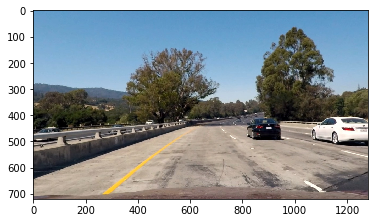

In [9]:
image=cv2.imread('test_images/test1.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
undist=undistort(image,calib[1],calib[2])
plt.imshow(undist)


### Color Transformation and Treshholding

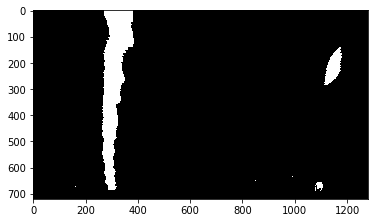

In [10]:
ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
combcol=color_threshold(image,5,5)

#plt.imshow(image)
gray=cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
binary=sob(undist,11)
combsob = np.zeros_like(binary[3])
combsob[((binary[3] == 1) &(binary[0] == 1) ) | ((binary[2] == 1)& (binary[3] == 1)) | ((binary[1] == 1)&(binary[3] == 1))] = 1

color_binary = np.dstack(( np.zeros_like(combcol), combcol, combsob))
combcol=color_threshold(image,7,7)
# Combine the two binary thresholds
combined_binary = np.zeros_like(combcol)
combined_binary[(combcol == 1) |(combsob == 1)] = 1
image=birdseyeview(combined_binary)[0]
plt.imshow(image,cmap='gray')
bild=slidewindow(birdseyeview(combined_binary)[0])


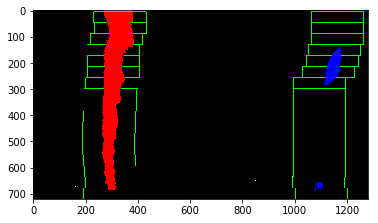

In [11]:
plt.imshow(bild[8])

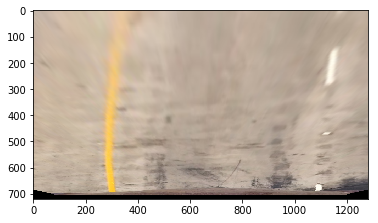

In [12]:
plt.imshow(birdseyeview(undist)[0])

(720, 0)

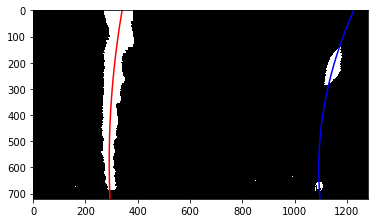

In [21]:
#plt.imshow(bild)
left_fitx=bild[4]
right_fitx=bild[5]
left_fit=bild[6]
right_fit=bild[7]
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )

plt.imshow(birdseyeview(combined_binary)[0],cmap='gray')
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
bild=slideadvanced(bild[8],left_fit,right_fit)
plt.imshow(birdseyeview(combined_binary)[0])
plt.plot(bild[4], ploty, color='yellow')
plt.plot(bild[5], ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'leftyy' is not defined

In [15]:
leftt=[]
rightt=[]
def createLines(left,right):
    global leftt,rightt
    n=10
    
    if len(leftt)<=n:
        #for i in range (n):
        leftt.append(left)
        rightt.append(right)
        
    else:
        del leftt[0]
        del rightt[0]
        
        leftt.append(left)
        rightt.append(right)
    return leftt,rightt

In [16]:
leftt=[]
rightt=[]

In [17]:
prevlineR=[]
prevlineL=[]
fitxR=None
fitxL=None
prevLX=None
prevLY=None
prevRX=None
prevRY=None
leftyy=None
leftxx=None
counter=1
prevlineL=[1.07718344e-04,  -1.01520147e-01  , 3.40205279e+02]
prevlineR=[4.47199399e-04,  -4.08928379e-01,   1.18884608e+03]
def process(image):
    global prevlineR,prevlineL,fitxL,fitxR,prevLX,prevLY,prevRX,prevRY,leftyy,rightyy,leftxx
    global left_fit,right_fit,counter#counter#,left_mean,right_mean
    
    #prevlineL=[1.07718344e-04,  -1.01520147e-01  , 3.40205279e+02]
    #prevlineR=[4.47199399e-04,  -4.08928379e-01,   1.18884608e+03]
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    undist=undistort(image,calib[1],calib[2])
    imagebird=birdseyeview(undist)[0]
    gray=cv2.cvtColor(imagebird,cv2.COLOR_RGB2GRAY)
    binary=sob(gray,11)
    combsob = np.zeros_like(binary[3])
    combsob[((binary[3] == 1) &(binary[0] == 1) ) | ((binary[2] == 1)& (binary[3] == 1)) | ((binary[1] == 1)&(binary[3] == 1))] = 1
    combcol=color_threshold(imagebird,5,5)
    combined_binary=stack_image(combcol,combsob)
    
    if (not np.all(prevlineR) or not np.all(prevlineL) ):#(counter==1):#
        
        #print(prevlineL)
        print('funzt')
        bild=slideadvanced(combined_binary,prevlineL,prevlineR)
        
        leftx = bild[0]
        lefty = bild[1]
        rightx = bild[2]
        righty = bild[3]
        left_fit=bild[6]
        right_fit=bild[7]
         #Fit a second order polynomial to each
        gg=bild[7]
        
        curve=curvature(combined_binary,leftx,lefty,rightx,righty)
        curve_err=((curve[0]-curve[1])**2)
        err_left= ((left_fit[0] -prevlineL[0])**2)
        err_right=((right_fit[0]-prevlineR[0])**2)
        print(err_left)
        print(err_right)
        ## check if error is smaller than 5%. If so, save linevalues. Else store values from previous frame!
        #if math.sqrt((curve_err))<=0.08:
        if math.sqrt((err_left))<=0.005:
            
            prevLX=leftx
            prevLY=lefty
            left_fitx=bild[4]
            prevlineL=bild[6]
            fitxL=left_fitx
            left_fit=bild[6]
            counter=0
        else:
            
            prevLX=prevLX
            prevLY=prevLY
            prevlineL=prevlineL
            left_fit=prevlineL
            left_fitx=fitxL
            counter=1
        #if math.sqrt((curve_err))<=0.08:
        if math.sqrt((err_right))<=0.005:
            
            prevRX=rightx
            prevRY=righty
            right_fitx=bild[5]
            prevlineR=bild[7]
            fitxR=right_fitx
            right_fit=bild[7]
            counter=0
        else:
            
            prevRX=prevRX
            prevRY=prevRY
            prevlineR=prevlineR
            right_fit=prevlineR
            right_fitx=fitxR
            counter=1
        
    
    else: 
        bild=slidewindow(combined_binary)
        
        leftx = bild[0]
        lefty = bild[1]
        rightx = bild[2]
        righty = bild[3]
        kk=bild[7]
        left_fit = bild[6]
        right_fit = bild[7]
        
        curve=curvature(combined_binary,leftx,lefty,rightx,righty)
        
        #prevlineL=left_fit
        #prevlineR=right_fit
        curve_err=((curve[0]-curve[1])**2)
        err_left= ((left_fit[0] -prevlineL[0])**2)
        err_right=((right_fit[0]-prevlineR[0])**2)
        
        if math.sqrt((err_left))<=0.005:
            
            prevLX=leftx
            prevLY=lefty
            left_fitx=bild[4]
            prevlineL=bild[6]
            fitxL=left_fitx
            left_fit=bild[6]
            counter=0
            
        else:
            prevLX=prevLX
            prevLY=prevLY
            prevlineL=prevlineL
            left_fit=prevlineL
            left_fitx=fitxL
            counter=1
        if math.sqrt((err_right) )<=0.005:
            prevRX=rightx
            prevRY=righty
            right_fitx=bild[5]
            prevlineR=bild[7]
            fitxR=right_fitx
            right_fit=bild[7]
            counter=0
            
        else:
            
            prevRX=prevRX
            prevRY=prevRY
            prevlineR=prevlineR
            right_fit=prevlineR
            right_fitx=fitxR
            counter=1
        
        
        
    
    data=createLines(left_fit,right_fit)
    left_mean=np.mean(data[0],axis=0)
    right_mean=np.mean(data[1],axis=0)
    left_list  = left_mean.tolist()
    right_list = right_mean.tolist()
    
    left_fitx = left_list[0]*ploty**2 + left_list[1]*ploty + left_list[2]
    right_fitx = right_list[0]*ploty**2 + right_list[1]*ploty + right_list[2]
    
    Minv=birdseyeview(combined_binary)[1]
    curve=curvature(combined_binary,bild[0],bild[1],bild[2],bild[3])

    draw,draw2=draw_lines(combined_binary,undist,Minv,left_fitx,right_fitx,curve[0],curve[1])
    
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    screen_mid = image.shape[1]/2
    y_eval = np.max(ploty)

    ll =  left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]    # x position for left lane
    rl = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]   # x position for right lane
    real_mid = int((rl + ll)/2)
    off_center = screen_mid-real_mid
    off_center = xm_per_pix * off_center   
    off_center = round(off_center,3)   
    
    
    height, width = 720, 1280
    Screen=np.zeros((height, width, 3), dtype=np.uint8)
    cv2.putText(draw, 'Offset from midlane {}(m)'.format(off_center), (60,80),
             fontFace = 1, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(draw, 'Radius of Curvature {}(m)'.format(int((curve[0]+curve[1])/2)), (60,120),
             fontFace = 1, fontScale = 2, color=(255,255,255), thickness = 2)
    kk=np.dstack((combined_binary, combined_binary, combined_binary))
    pic = np.dstack((combined_binary, combined_binary, combined_binary))*255
    Screen[0:720,0:960] = cv2.resize(draw, (int(width*3/4),int(height)), interpolation=cv2.INTER_AREA)    
    Screen[0:240,960:1280] = cv2.resize((birdseyeview(undist)[0]), (320,240), interpolation=cv2.INTER_AREA)
    Screen[240:480,960:1280] = cv2.resize(bild[8], (320,240), interpolation=cv2.INTER_AREA)
    Screen[480:720,960:1280] = cv2.resize(draw2, (320,240), interpolation=cv2.INTER_AREA)
    return Screen

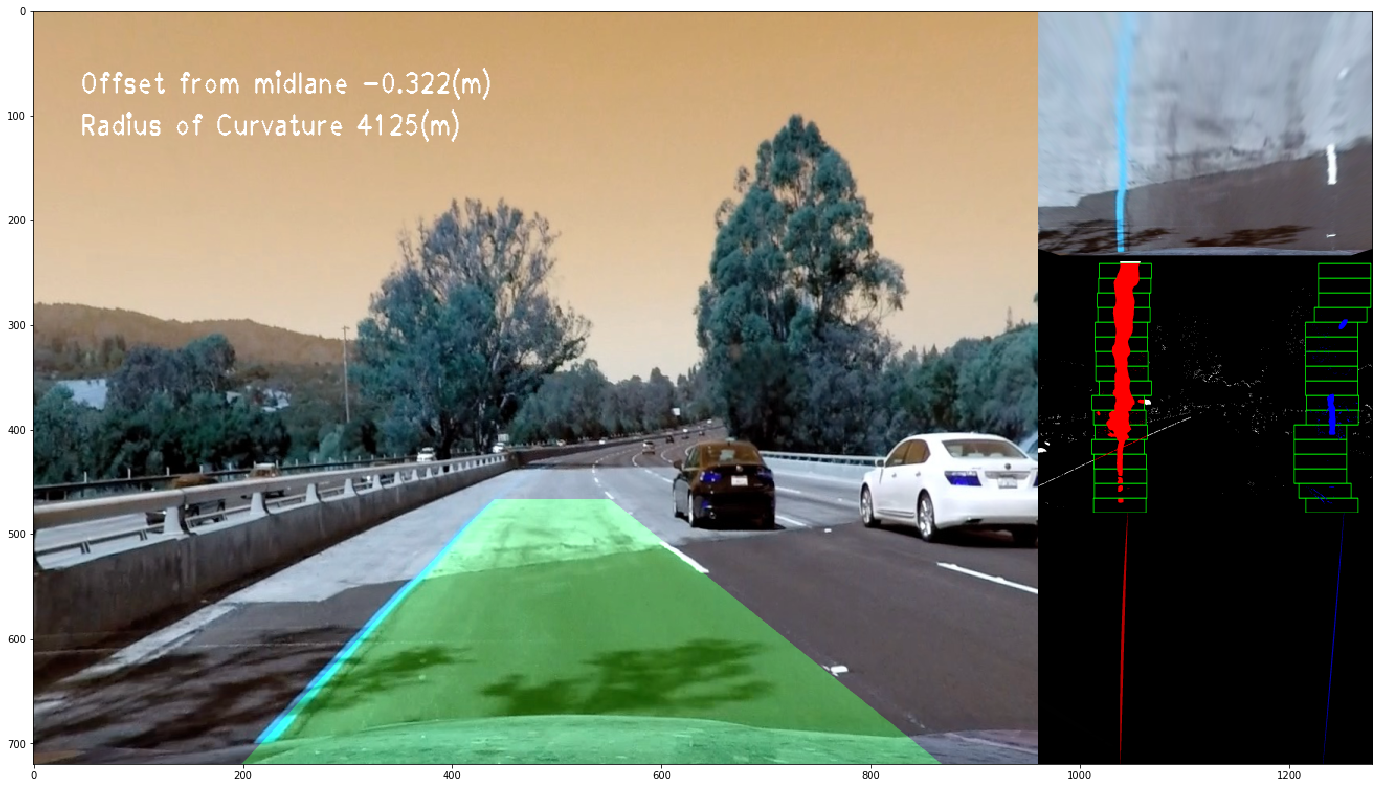

In [18]:
plt.figure(figsize=(24, 15))
image=cv2.imread('test_images/test4.jpg')
nice=process(image)
plt.imshow(nice)

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [18]:
white_output = "challenge.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:34<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 

Wall time: 4min 35s


In [ ]:
kk=[0.,0.,0.]
print(np.all(kk))